<a href="https://colab.research.google.com/github/eoinleen/AKTA-Prime_final/blob/main/Vnadas_AKTA_SEC_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SEC Analysis Plotter Ready!
Modify the configuration section above to match your data, then run:
results = plot_sec_analysis()
Please upload your Excel file:


Saving 20250222-mysm1_mm-r3.xlsx to 20250222-mysm1_mm-r3 (18).xlsx
Using file: 20250222-mysm1_mm-r3 (18).xlsx
Available columns:
  0: 'ml'
  1: 'mAU'
  2: 'ml.1'
  3: '%'
  4: 'ml.2'
  5: 'mS/cm'
  6: 'ml.3'
  7: 'Injection'
  8: 'ml.4'
  9: 'Fraction'
  10: 'ml.5'
  11: 'mAU.1'

Data Summary:
Volume range: -0.000 to 19.421 mL
Absorbance range: -0.099 to 97.294 mAU
Fraction range: 0.000 to 19.421 mL
Total data points: 29160
Plot saved as: ./sec_plot.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot downloaded as: sec_analysis_plot.png


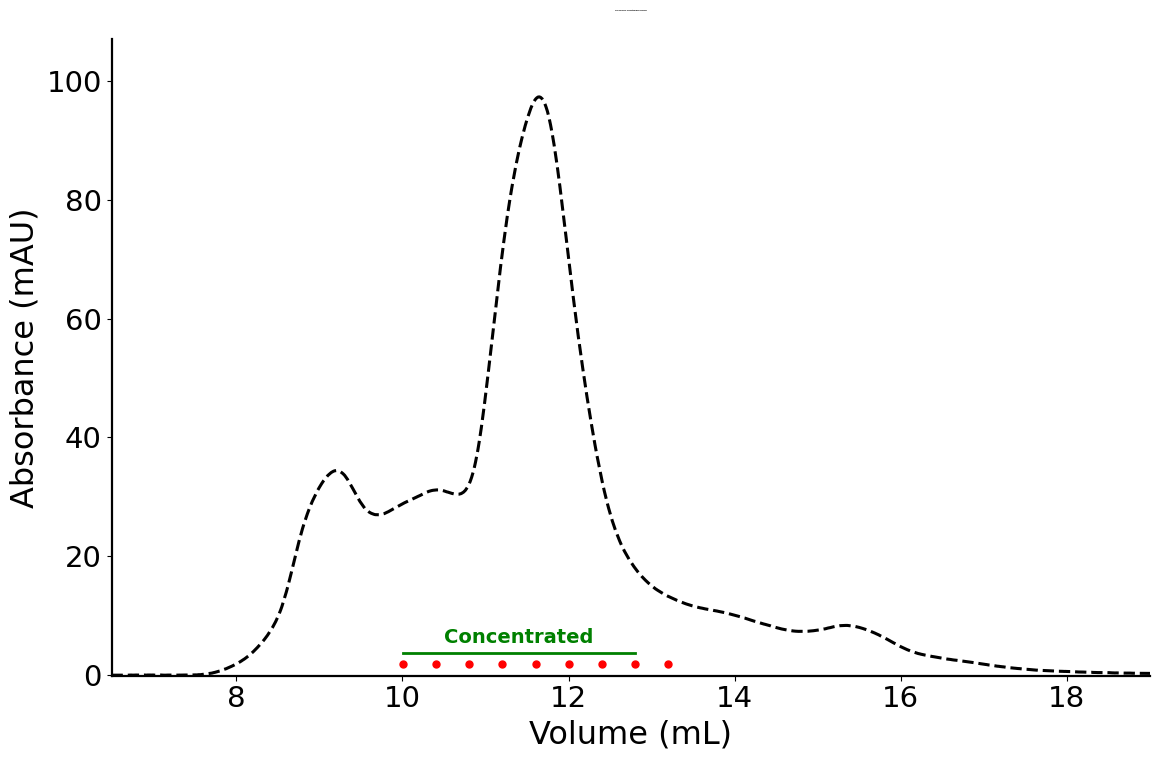


Peak Analysis:
Maximum absorbance: 97.294 mAU
Peak volume: 11.641 mL


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import io
import base64

# ==============================================================================
# CONFIGURATION SECTION - MODIFY THESE VALUES AS NEEDED
# ==============================================================================

# File path options:
FILE_PATH = None  # Set to None to trigger file upload prompt

# Fraction collection range (in mL) - adjust for your bottom graph
FRACTION_START = 10.002
FRACTION_END = 13.603

# Concentrated fractions range (subset of fractions to be concentrated)
CONCENTRATE_START = 10.002  # Starting point for concentration
CONCENTRATE_END = 12.800    # Ending point for concentration

# Display range on the x-axis (in mL)
X_AXIS_MIN = 6.5
X_AXIS_MAX = 19.0

# Column indices for your specific AKTA file format (0-based indices)
VOLUME_COLUMN = 0         # ml (volume) column - Column A
ABSORBANCE_COLUMN = 1     # mAU (absorbance) column - Column B
CONDUCTIVITY_COLUMN = 3   # mS/cm (conductivity) column (if available)
FRACTION_VOL_COLUMN = 8   # ml for fractions - Column I
FRACTION_NUM_COLUMN = 9   # Fraction numbers (if available)

# Data processing options
HEADER_ROW = 2            # Row with column headers (0-based, so row 3 = index 2)
DATA_START_ROW = 3        # Row where data begins (0-based, so row 4 = index 3)

# Styling settings to match top graph
SHOW_CONDUCTIVITY = False  # Hide conductivity for cleaner look
SAVE_OUTPUT = True
AUTO_DOWNLOAD = True
OUTPUT_PATH = './sec_plot.png'
DOWNLOAD_FILENAME = 'sec_analysis_plot.png'
SHOW_LEGEND = False       # Clean look without legend
SHOW_FRACTION_LABEL = False  # Clean look
SHOW_CONCENTRATION = True    # Show concentrated fractions
USE_TOP_GRAPH_STYLE = True   # New flag for consistent styling

# Font sizes for publication-quality figures
FONT_SIZES = {
    'general': 20,    # Overall font size
    'title': 1,      # Title font size
    'labels': 23,     # Axis label font size
    'ticks': 21,      # Tick label font size
    'annotations': 14 # Annotation font size
}

# ==============================================================================
# MAIN PLOTTING FUNCTION
# ==============================================================================

def plot_sec_analysis():
    """
    Main function to plot SEC analysis with configurable parameters
    """

    # Handle file input
    if FILE_PATH is None:
        print("Please upload your Excel file:")
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        print(f"Using file: {filename}")
    else:
        filename = FILE_PATH

    # Read the Excel file
    try:
        df = pd.read_excel(filename, header=HEADER_ROW)
        print("Available columns:")
        for i, col in enumerate(df.columns):
            print(f"  {i}: '{col}'")
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Extract data using configured column indices
    try:
        volume_data = pd.to_numeric(df.iloc[:, VOLUME_COLUMN], errors='coerce')
        absorbance_data = pd.to_numeric(df.iloc[:, ABSORBANCE_COLUMN], errors='coerce')

        # Try to get fraction data if column exists
        fraction_data = None
        if FRACTION_VOL_COLUMN < len(df.columns):
            fraction_data = pd.to_numeric(df.iloc[:, FRACTION_VOL_COLUMN], errors='coerce')

        # Clean the main chromatogram data
        mask = volume_data.notna() & absorbance_data.notna()
        volume_clean = volume_data[mask]
        absorbance_clean = absorbance_data[mask]

        # Clean fraction data if available
        fraction_clean = None
        if fraction_data is not None:
            fraction_clean = fraction_data[fraction_data.notna()]

    except Exception as e:
        print(f"Error extracting data: {e}")
        print("Please check your column indices in the configuration section.")
        return None

    print(f"\nData Summary:")
    print(f"Volume range: {volume_clean.min():.3f} to {volume_clean.max():.3f} mL")
    print(f"Absorbance range: {absorbance_clean.min():.3f} to {absorbance_clean.max():.3f} mAU")
    if fraction_clean is not None:
        print(f"Fraction range: {fraction_clean.min():.3f} to {fraction_clean.max():.3f} mL")
    print(f"Total data points: {len(volume_clean)}")

    # Set font properties
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'font.size': FONT_SIZES['general'],
        'axes.titlesize': FONT_SIZES['title'],
        'axes.labelsize': FONT_SIZES['labels'],
        'xtick.labelsize': FONT_SIZES['ticks'],
        'ytick.labelsize': FONT_SIZES['ticks']
    })

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot main chromatogram
    if USE_TOP_GRAPH_STYLE:
        # Black dashed line to match reference style
        ax.plot(volume_clean, absorbance_clean, 'k--', linewidth=2.2, label='UV 280nm')
    else:
        # Solid blue line
        ax.plot(volume_clean, absorbance_clean, 'b-', linewidth=2.2, label='UV 280nm')

    # Calculate y-axis limits for markers
    y_min = absorbance_clean.min()
    y_max = absorbance_clean.max()
    y_range = y_max - y_min

    # Add fraction markers as red dots - only in specified range
    marker_y = y_min + y_range * 0.02

    if fraction_clean is not None and len(fraction_clean) > 0:
        # Filter fraction data to only show markers in the specified range
        fraction_in_range = fraction_clean[
            (fraction_clean >= FRACTION_START) &
            (fraction_clean <= FRACTION_END)
        ]
        if len(fraction_in_range) > 0:
            ax.scatter(fraction_in_range, [marker_y]*len(fraction_in_range),
                       c='red', s=25, label='Fractions', zorder=3)
        else:
            # Fallback: use evenly spaced markers in the specified range
            fraction_volumes = np.linspace(FRACTION_START, FRACTION_END, 20)
            ax.scatter(fraction_volumes, [marker_y]*len(fraction_volumes),
                       c='red', s=25, label='Fractions', zorder=3)
    else:
        # Use configured fraction range for markers
        fraction_volumes = np.linspace(FRACTION_START, FRACTION_END, 20)
        ax.scatter(fraction_volumes, [marker_y]*len(fraction_volumes),
                   c='red', s=25, label='Fractions', zorder=3)

    # Add concentration region
    if SHOW_CONCENTRATION:
        line_y = y_min + y_range * 0.04  # Moved down from 0.08 to 0.04
        ax.plot([CONCENTRATE_START, CONCENTRATE_END], [line_y, line_y],
                'green', linewidth=2, zorder=4)  # Reduced from 3 to 2

        # Add "Concentrated" text - closer to the line
        text_x = (CONCENTRATE_START + CONCENTRATE_END) / 2
        text_y = line_y + y_range * 0.01  # Reduced from 0.03 to 0.01 for closer text
        ax.text(text_x, text_y, 'Concentrated', ha='center', va='bottom',
                color='green', fontsize=FONT_SIZES['annotations'], fontweight='bold')

    # Formatting
    ax.set_xlabel('Volume (mL)', fontsize=FONT_SIZES['labels'])
    ax.set_ylabel('Absorbance (mAU)', fontsize=FONT_SIZES['labels'])
    ax.set_title('Size Exclusion Chromatography Analysis',
                 fontsize=FONT_SIZES['title'], fontweight='bold', pad=20)

    # Set axis limits
    ax.set_xlim(X_AXIS_MIN, X_AXIS_MAX)
    ax.set_ylim(y_min * 0.9, y_max * 1.1)

    # Clean up plot appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.6)
    ax.spines['bottom'].set_linewidth(1.6)

    if USE_TOP_GRAPH_STYLE:
        ax.grid(False)  # No grid for clean look
        ax.set_facecolor('none')
    else:
        ax.grid(True, alpha=0.3)

    # Legend only if requested
    if SHOW_LEGEND:
        ax.legend(loc='upper right', frameon=False)

    plt.tight_layout()

    # Save and download if requested
    if SAVE_OUTPUT:
        plt.savefig(OUTPUT_PATH, dpi=300, bbox_inches='tight',
                   transparent=True, facecolor='none', edgecolor='none')
        print(f"Plot saved as: {OUTPUT_PATH}")

        if AUTO_DOWNLOAD:
            files.download(OUTPUT_PATH)
            print(f"Plot downloaded as: {DOWNLOAD_FILENAME}")

    plt.show()

    # Find and report peak information
    max_abs_idx = absorbance_clean.idxmax()
    max_abs_value = absorbance_clean.max()
    max_abs_volume = volume_clean.iloc[max_abs_idx]

    print(f"\nPeak Analysis:")
    print(f"Maximum absorbance: {max_abs_value:.3f} mAU")
    print(f"Peak volume: {max_abs_volume:.3f} mL")

    return {
        'volume': volume_clean,
        'absorbance': absorbance_clean,
        'peak_volume': max_abs_volume,
        'peak_absorbance': max_abs_value
    }

# ==============================================================================
# RUN THE ANALYSIS
# ==============================================================================

print("SEC Analysis Plotter Ready!")
print("Modify the configuration section above to match your data, then run:")
print("results = plot_sec_analysis()")

# Run the analysis - this will prompt for file upload:
results = plot_sec_analysis()